In [23]:
# Set-up plotting.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [233]:
import time
from numpy import (arange, argmax, argsort, corrcoef, cov, dot, empty, floor, hstack, max, pow, roll,
                   triu_indices, vstack, zeros)
from numpy.linalg import norm
from numpy.random import rand, randn
from scipy.linalg import eigh

In [257]:
# Example of learning dictionary with ADMM and ALS.

# Create example.
n = 100 # number of neurons
k = 4 # number of dictionary elements
triu_idx = triu_indices(n)

# Generate structured weights...
chk_len = 50
shift = 0.5
n_samp = chk_len + floor((k - 1) * shift * chk_len) # number of input covariances
x = arange(chk_len) / float(chk_len)
template = hstack((-(x - 0.5) ** 2 + 0.3, zeros((k - 1) * chk_len)))
W = vstack([roll(template, int(i * shift * chk_len)) for i in range(k)])
W = W[:, : n_samp]

# ...and random covariance dictionary as ground truth.
D = vstack([cov(randn(n, n))[triu_idx] for i in range(k)]).T

# Simulate covariance over time.
X = dot(D, W)

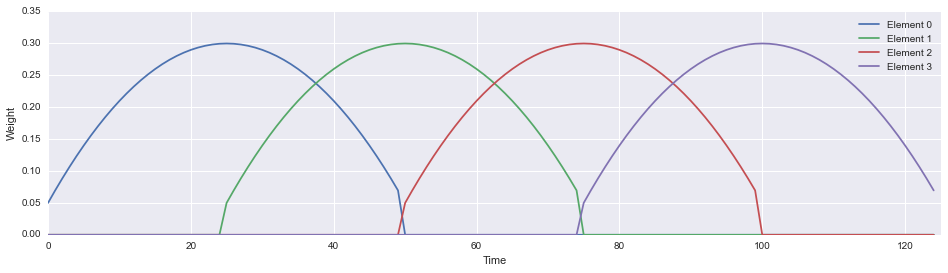

In [258]:
# Plot weights of each dictionary element over time.
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));
plt.plot(W.T);

plt.xlim(0, n_samp);
plt.ylim(0, max(W) + 0.05);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.legend(['Element ' + str(i) for i in range(k)]);

In [ ]:
# Learn dictionary using ALS.
reload(covdict)

als = covdict.CovarianceDictionary(k=k, method='als', verbose=True, nls_beta=0.25, psdls_beta=0.25)
t = time.time()
West_als = als.fit_transform(X)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights.
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(West_als.T);
plt.xlim(0, n_samp);
plt.xlabel('Time');
plt.ylabel('Weight');

Initial gradient norm: 200.838662.
Iter: 0. Projected gradient norm: 200.837747. Objective: 0.785153.


In [244]:
# Match ALS-recovered and corresponding true dictionary elements.
match_idx = argsort(argmax(West_als, axis=1))

# Correlate to measure accuracy to account for scale factor.
for a, b in zip(als.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

0.999999993834
0.999999999947
0.999999999947
0.999999913933


Iter: 0. Objective: 0.710782.
Iter: 500. Objective: 0.049789.
Iter: 805. Objective: 0.035441.
16.8362181187 seconds


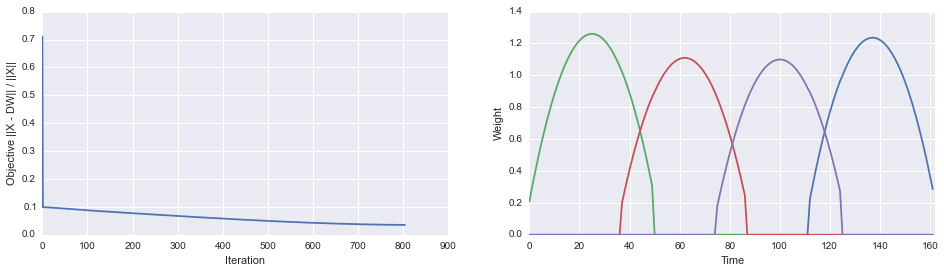

In [245]:
# Learn dictionary using ADMM.
reload(covdict)

admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, admm_gamma=0.2)
t = time.time()
West_admm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights.
# Well-established linear convergence of ADMM is obvious.
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(West_admm.T);
plt.xlim(0, n_samp);
plt.xlabel('Time');
plt.ylabel('Weight');

In [246]:
# Match ADMM-recovered and corresponding true dictionary elements.
match_idx = argsort(argmax(West_admm, axis=1))

# Correlate to measure accuracy to account for scale factor.
for a, b in zip(als.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

0.999730809571
0.999495341387
0.999597131397
0.999744880712


In [256]:
# Compare performance for different n, k.
reload(covdict)
n_vals = [10, 20, 50]
k_vals = [2, 4, 8]
n_trial = 10

t_als = zeros((len(n_vals), len(k_vals)))
t_admm = zeros((len(n_vals), len(k_vals)))

for i, n in enumerate(n_vals):
    for j, k in enumerate(k_vals):
        for _ in range(n_trial):

            # Generate random dictionary and weights.
            D = vstack([cov(randn(n, n))[triu_indices(n)] for i in range(k)]).T
            W = rand(k, n * (n + 1) / 2)
            X = dot(D, W)

            t = time.time()
            als = covdict.CovarianceDictionary(k=k, method='als', obj_tol=1e-2)
            als.fit_transform(X)
            t_als[i, j] += time.time() - t

            t = time.time()
            admm = covdict.CovarianceDictionary(k=k, method='admm', obj_tol=1e-2)
            admm.fit_transform(X)
            t_admm[i, j] += time.time() - t
        
        print i, j

KeyboardInterrupt: 